In [34]:
# Installing Dependencies
!pip install pandas requests matplotlib seaborn


In [35]:
# Importing Necessary Libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# API Configuration
API_KEY = "630602dd83c94400bc706b73c29786ed"
HEADERS = {"X-Auth-Token": API_KEY}

# Base URL of the Football-Data API
BASE_URL = "https://api.football-data.org/v4"


In [36]:
# PL = Premier League, PD= La Liga, BL1= Bundesliga, SA= Serie A
# Following Function fetches match data of the given football competitions
def fetch_leagues_current_season(competitions=["PL", "PD", "BL1", "SA"]):
    all_matches = []

    for comp in competitions:
        print(f"Fetching {comp} season 2023...")

        # Build API endpoint URL for the competition
        url = f"{BASE_URL}/competitions/{comp}/matches?season=2023"
        response = requests.get(url, headers=HEADERS)

        # Skip if request fails
        if response.status_code != 200:
            print(f"Failed to fetch {comp}: {response.status_code}")
            continue

        # Extract match data and store relevant fields
        matches = response.json().get("matches", [])
        for match in matches:
            all_matches.append({
                "competition": comp,
                "date": match["utcDate"],
                "home_team": match["homeTeam"]["name"],
                "away_team": match["awayTeam"]["name"],
                "status": match["status"],
                "score_home": match["score"]["fullTime"]["home"],
                "score_away": match["score"]["fullTime"]["away"]
            })
    # Converts the collected data into a pandas DataFrame
    return pd.DataFrame(all_matches)


In [37]:
# Fetch data from API
df_raw = fetch_leagues_current_season()
print("Total matches fetched:", len(df_raw))

# Save the raw data locally for persistence
df_raw.to_csv("raw_data.csv", index=False)

# Load raw data (could skip if df_raw is still available)
df = pd.read_csv("raw_data.csv")


Fetching PL season 2023...
Fetching PD season 2023...
Fetching BL1 season 2023...
Fetching SA season 2023...
Total matches fetched: 1446


In [38]:
# Print Original shape of the data
print("Original shape:", df.shape)

Original shape: (1446, 7)


In [39]:
# Check for duplicates
num_duplicates_before = df.duplicated().sum()
print(f"Duplicate rows before dropping: {num_duplicates_before}")

# Drop duplicates
df.drop_duplicates(inplace=True)
print("After removing duplicates:", df.shape)


Duplicate rows before dropping: 0
After removing duplicates: (1446, 7)


In [40]:
# Drop rows with missing essential fields
df.dropna(subset=["score_home", "score_away", "home_team", "away_team", "date"], inplace=True)
print("After dropping missing values:", df.shape)

After dropping missing values: (1446, 7)


In [41]:
# Convert date column to datetime format
df["date"] = pd.to_datetime(df["date"])

# Sort the data by date (ascending)
df.sort_values(by="date", inplace=True)

In [42]:
# Reset index
df.reset_index(drop=True, inplace=True)

# Save cleaned dataset
df.to_csv("cleaned_data.csv", index=False)
print("✅ Cleaned dataset saved as cleaned_data.csv")
df.head()

✅ Cleaned dataset saved as cleaned_data.csv


,competition,date,home_team,away_team,status,score_home,score_away
0,PD,2023-08-11 17:30:00+00:00,UD Almería,Rayo Vallecano de Madrid,FINISHED,0,2
1,PL,2023-08-11 19:00:00+00:00,Burnley FC,Manchester City FC,FINISHED,0,3
2,PD,2023-08-11 20:00:00+00:00,Sevilla FC,Valencia CF,FINISHED,1,2
3,PL,2023-08-12 12:00:00+00:00,Arsenal FC,Nottingham Forest FC,FINISHED,2,1
4,PL,2023-08-12 14:00:00+00:00,AFC Bournemouth,West Ham United FC,FINISHED,1,1


In [43]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Load the cleaned match data
df = pd.read_csv("cleaned_data.csv")

# Convert the date column from string to datetime format
df["date"] = pd.to_datetime(df["date"])

# Preview the first 5 rows of the dataset
df.head()


,competition,date,home_team,away_team,status,score_home,score_away
0,PD,2023-08-11 17:30:00+00:00,UD Almería,Rayo Vallecano de Madrid,FINISHED,0,2
1,PL,2023-08-11 19:00:00+00:00,Burnley FC,Manchester City FC,FINISHED,0,3
2,PD,2023-08-11 20:00:00+00:00,Sevilla FC,Valencia CF,FINISHED,1,2
3,PL,2023-08-12 12:00:00+00:00,Arsenal FC,Nottingham Forest FC,FINISHED,2,1
4,PL,2023-08-12 14:00:00+00:00,AFC Bournemouth,West Ham United FC,FINISHED,1,1


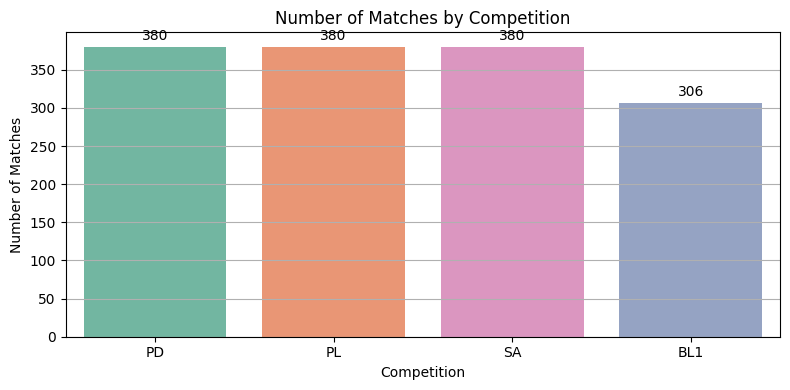

In [44]:
# Plotting the number of matches per competition using Seaborn

plt.figure(figsize=(8, 4))

# Create a countplot for competitions with distinct colors
ax = sns.countplot(
    data=df,
    x="competition",
    hue="competition",
    order=df["competition"].value_counts().index,
    palette="Set2",
    legend=False
)

# Add chart title and axis labels
plt.title("Number of Matches by Competition")
plt.xlabel("Competition")
plt.ylabel("Number of Matches")
plt.grid(axis="y")

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, int(height), ha='center', va='bottom', fontsize=10)

# Adjust layout to avoid clipping
plt.tight_layout()
plt.show()


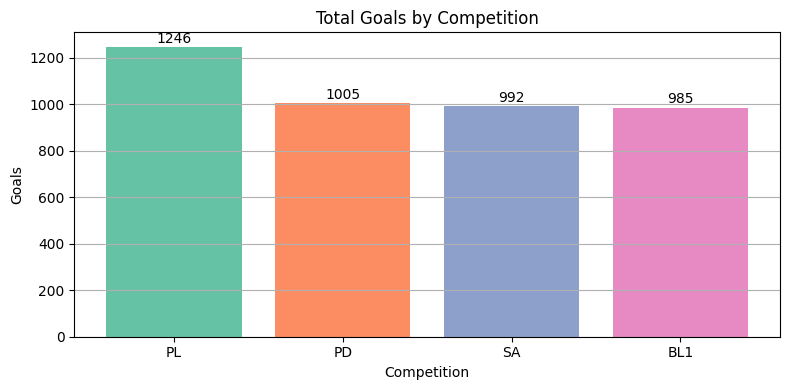

In [45]:
# Add a new column that calculates the total goals per match
df["total_goals"] = df["score_home"] + df["score_away"]

# Aggregate total goals scored in each competition and sort in descending order
goal_data = df.groupby("competition")["total_goals"].sum().sort_values(ascending=False)

# Generate distinct colors for each bar using the Set2 colormap
colors = plt.cm.Set2(range(len(goal_data)))

# Create bar plot
plt.figure(figsize=(8, 4))
bars = plt.bar(goal_data.index, goal_data.values, color=colors)
plt.title("Total Goals by Competition")
plt.ylabel("Goals")
plt.xlabel("Competition")
plt.grid(axis="y")

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, int(yval), ha='center', va='bottom', fontsize=10)

# Adjust layout to avoid clipping
plt.tight_layout()
plt.show()


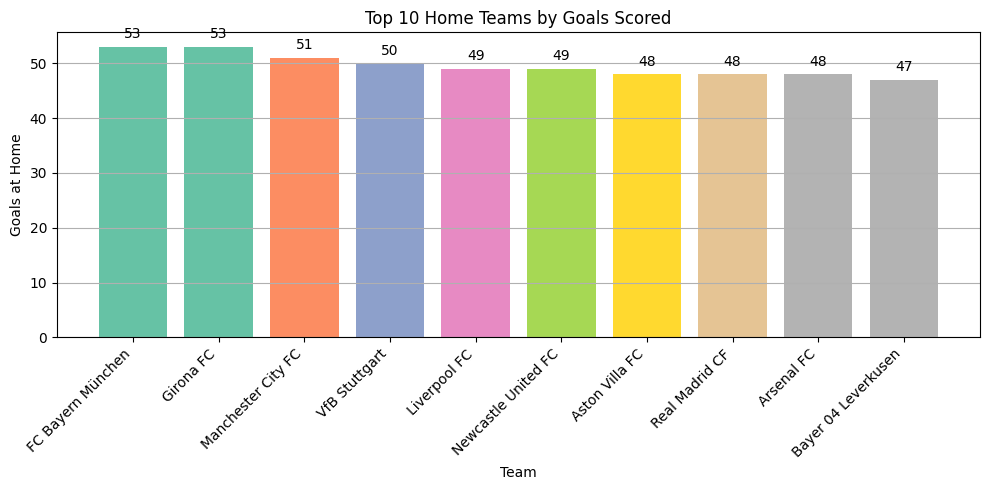

In [46]:
# Get top 10 home scoring teams
top_home_teams = df.groupby("home_team")["score_home"].sum().sort_values(ascending=False).head(10)

# Generate distinct colors from Set2 colormap
colors = plt.cm.Set2(np.linspace(0, 1, len(top_home_teams)))

# Create the bar plot
plt.figure(figsize=(10, 5))
bars = plt.bar(top_home_teams.index, top_home_teams.values, color=colors)
plt.title("Top 10 Home Teams by Goals Scored")
plt.xlabel("Team")
plt.ylabel("Goals at Home")
plt.grid(axis="y")

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right')

# Add goal labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Adjust layout to avoid clipping
plt.tight_layout()
plt.show()


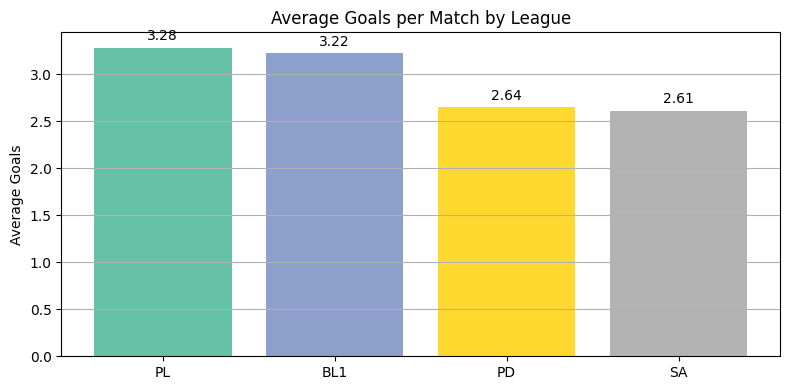

In [47]:
# Calculate average goals per competition
avg_goals = df.groupby("competition")["total_goals"].mean().sort_values(ascending=False)

# Generate unique colors using Set2 colormap
colors = plt.cm.Set2(np.linspace(0, 1, len(avg_goals)))

# Plot
plt.figure(figsize=(8, 4))
bars = plt.bar(avg_goals.index, avg_goals.values, color=colors)
plt.title("Average Goals per Match by League")
plt.ylabel("Average Goals")
plt.grid(axis="y")

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

# Adjust layout to avoid clipping
plt.tight_layout()
plt.show()


/tmp/ipython-input-48-2192492107.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M").astype(str)


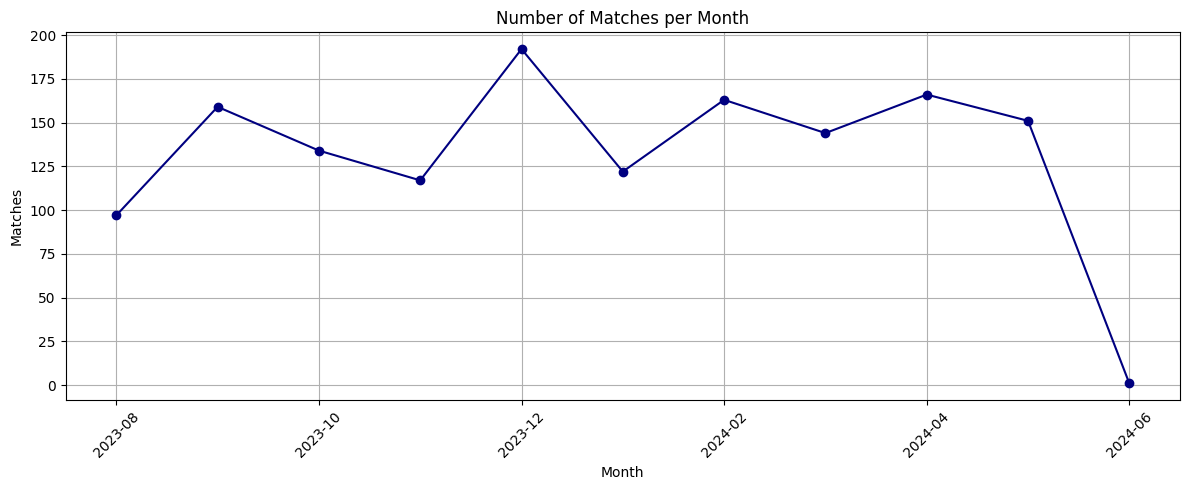

In [48]:
# Extract the month (YYYY-MM) from the date column and add it as a new column
df["month"] = df["date"].dt.to_period("M").astype(str)

# Count the number of matches played in each month
monthly_matches = df.groupby("month").size()

# Plot the number of matches per month as a line chart
plt.figure(figsize=(12, 5))
monthly_matches.plot(kind="line", marker="o", linestyle="-", color="navy")
plt.title("Number of Matches per Month")
plt.xlabel("Month")
plt.ylabel("Matches")
plt.xticks(rotation=45)
plt.grid(True)

# Adjust layout to avoid clipping
plt.tight_layout()
plt.show()


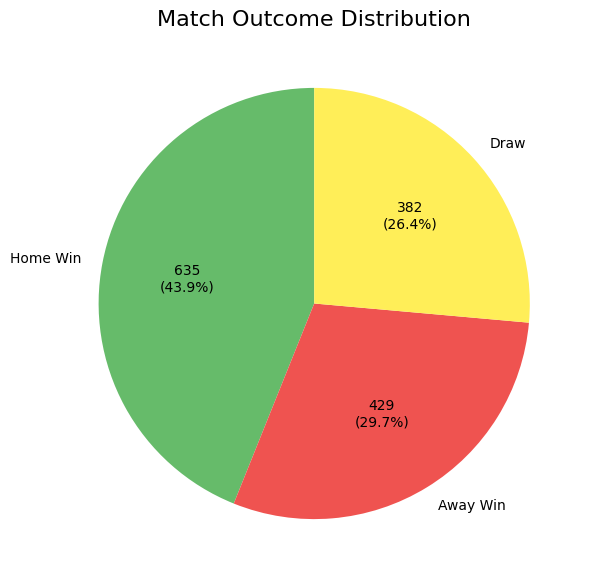

In [49]:
# Function to determine match result based on scores
def get_result(row):
    if row["score_home"] > row["score_away"]:
        return "Home Win"
    elif row["score_home"] < row["score_away"]:
        return "Away Win"
    else:
        return "Draw"

# Apply the result function to each row and store in a new result column
df["result"] = df.apply(get_result, axis=1)

# Count the number of each result type
result_counts = df["result"].value_counts()
total_matches = result_counts.sum()

# Function to display both count and percentage in pie chart
def countperc(pct, allvalues):
    absolute = int(round(pct/100.*sum(allvalues)))
    return f"{absolute}\n({pct:.1f}%)"

# Plot the match outcome distribution as a pie chart
plt.figure(figsize=(7,7))
result_counts.plot(
    kind="pie",
    autopct=lambda pct: countperc(pct, result_counts),
    startangle=90,
    colors=["#66bb6a", "#ef5350", "#ffee58"]
)

# Chart styling
plt.title("Match Outcome Distribution", fontsize=16)
plt.ylabel("")
plt.show()
